# Demo: sampling from Huggingface's CIFAR10 DDPM, but after fine-tuning it with ITdiffusion

### Imports and setup

In [1]:
import time
import numpy as np
import math
import tqdm
from tqdm import trange

In [2]:
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Get fine-tuned model's pytorch checkpoint (saved on my google drive)

In [3]:
# Huggingface hub directory from which we get the pre-trained CIFAR10 DDPM model's config 
model_id = "google/ddpm-cifar10-32"

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!ls drive/MyDrive/density_estimation/checkpoints/ddpm

model_epoch10.pt


In [6]:
import os

In [7]:
dir_ddpm_fine_tuned_pt = "drive/MyDrive/density_estimation/checkpoints/ddpm/"
path_ddpm_fine_tuned_pt = os.path.join(dir_ddpm_fine_tuned_pt, "model_epoch10.pt")

In [8]:
!stat $path_ddpm_fine_tuned_pt

  File: drive/MyDrive/density_estimation/checkpoints/ddpm/model_epoch10.pt
  Size: 143106097 	Blocks: 279505     IO Block: 65536  regular file
Device: 2ah/42d	Inode: 505         Links: 1
Access: (0600/-rw-------)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2023-04-27 03:31:59.000000000 +0000
Modify: 2023-04-27 03:27:04.000000000 +0000
Change: 2023-04-27 03:31:59.000000000 +0000
 Birth: -


### Utils for displaying samples

In [9]:
import PIL.Image
import numpy as np

def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

## Sample from CIFAR10 DDPM fine-tuned with ITdiffusion
The model here is the result of using ITdiffusion to fine-tune the original CIFAR10 DDPM (from Huggingface, pre-trained)

### Set up model

In [10]:
import torch
# import torch.nn as nn
# import torch.nn.functional as F

from diffusers import UNet2DModel

ITdiffusion's wrapper for huggingface's UNet2DModel, to be compatible with their ITdiffusion implementation for fine-tuning

In [11]:
# class WrapUNet2DModel(UNet2DModel):
#     """Wrap UNet2DModel to accept arguments compatible with Diffusion Model."""
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)

#     def forward(self, z, snr):
#         x = z[0]
#         timestep = self.logsnr2t(torch.log(snr))
#         eps_hat = super().forward(x, timestep).sample
#         return eps_hat

#     def logsnr2t(self, logsnr):
#         num_diffusion_steps = 10000 # improve the timestep precision
#         alphas_cumprod = torch.sigmoid(logsnr)
#         scale = 1000 / num_diffusion_steps
#         beta_start = scale * 0.0001
#         beta_end = scale * 0.02
#         betas = np.linspace(beta_start, beta_end, num_diffusion_steps, dtype=np.float64)
#         alphas = 1.0 - betas
#         alphabarGT = torch.tensor(np.cumprod(alphas, axis=0), device=alphas_cumprod.device)
#         timestep = torch.argmin(abs(alphabarGT-alphas_cumprod.unsqueeze(1)), dim=1) * scale
#         return timestep

In [12]:
checkpoint = torch.load(path_ddpm_fine_tuned_pt)

Load model config from hub for pre-trained cifar10 ddpm, but use state dict (weights) from the model after fine-tuning with ITdiffusion

In [13]:
model = UNet2DModel.from_pretrained(model_id) # was originally called modelB in ITdiffusion implementation bc they want to wrap it
# model = WrapUNet2DModel(**modelB.config)
# model.load_state_dict(modelB.state_dict())
model.load_state_dict(checkpoint)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


<All keys matched successfully>

In [14]:
# model

In [15]:
# model.config

In [16]:
model.save_pretrained("my_model")

In [17]:
!ls my_model

config.json  diffusion_pytorch_model.bin


In [18]:
# model = UNet2DModel.from_pretrained("my_model")

### Set up scheduler

In [19]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler.from_config(model_id)

/usr/local/lib/python3.9/dist-packages/diffusers/configuration_utils.py:215: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [20]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_large'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.1.1')])

In [21]:
scheduler.save_config("my_scheduler")
# new_scheduler = DDPMScheduler.from_config("my_scheduler")

### Set up sampling

In [22]:
torch.manual_seed(0)

noisy_sample = torch.randn(
    1, model.config.in_channels, model.config.sample_size, model.config.sample_size
)
noisy_sample.shape

torch.Size([1, 3, 32, 32])

In [23]:
with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2).sample

In [24]:
noisy_residual.shape

torch.Size([1, 3, 32, 32])

### Generate samples

In [25]:
less_noisy_sample = scheduler.step(
    model_output=noisy_residual, timestep=2, sample=noisy_sample
).prev_sample
less_noisy_sample.shape

torch.Size([1, 3, 32, 32])

In [26]:
model.to("cuda")
noisy_sample = noisy_sample.to("cuda")

  5%|▍         | 46/1000 [00:10<00:46, 20.50it/s]

'Image at step 50'

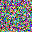

  9%|▉         | 94/1000 [00:11<00:17, 51.66it/s]

'Image at step 100'

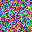

 15%|█▍        | 148/1000 [00:12<00:15, 56.06it/s]

'Image at step 150'

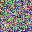

 20%|█▉        | 196/1000 [00:13<00:14, 56.12it/s]

'Image at step 200'

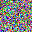

 24%|██▍       | 244/1000 [00:14<00:14, 53.76it/s]

'Image at step 250'

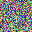

 30%|██▉       | 298/1000 [00:15<00:12, 54.51it/s]

'Image at step 300'

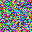

 35%|███▍      | 346/1000 [00:16<00:11, 54.90it/s]

'Image at step 350'

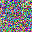

 40%|███▉      | 397/1000 [00:17<00:14, 42.12it/s]

'Image at step 400'

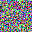

 45%|████▍     | 449/1000 [00:18<00:13, 39.76it/s]

'Image at step 450'

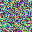

 50%|████▉     | 498/1000 [00:20<00:12, 39.10it/s]

'Image at step 500'

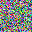

 55%|█████▍    | 547/1000 [00:21<00:08, 53.48it/s]

'Image at step 550'

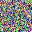

 60%|█████▉    | 595/1000 [00:21<00:07, 55.23it/s]

'Image at step 600'

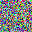

 65%|██████▍   | 649/1000 [00:22<00:06, 53.99it/s]

'Image at step 650'

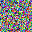

 70%|██████▉   | 697/1000 [00:23<00:05, 55.17it/s]

'Image at step 700'

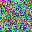

 74%|███████▍  | 745/1000 [00:24<00:04, 56.42it/s]

'Image at step 750'

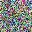

 80%|███████▉  | 799/1000 [00:25<00:03, 56.83it/s]

'Image at step 800'

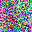

 85%|████████▍ | 847/1000 [00:26<00:02, 54.56it/s]

'Image at step 850'

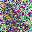

 90%|████████▉ | 895/1000 [00:27<00:01, 55.27it/s]

'Image at step 900'

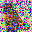

 95%|█████████▍| 949/1000 [00:28<00:00, 55.15it/s]

'Image at step 950'

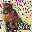

100%|█████████▉| 997/1000 [00:29<00:00, 54.94it/s]

'Image at step 1000'

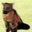

100%|██████████| 1000/1000 [00:29<00:00, 34.05it/s]

CPU times: user 20.6 s, sys: 806 ms, total: 21.4 s
Wall time: 29.4 s


In [27]:
%%time

sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t).sample

  # 2. compute less noisy image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample).prev_sample

  # 3. optionally look at image
  if (i + 1) % 50 == 0:
      display_sample(sample, i + 1)

## Sample from original CIFAR10 DDPM (from Huggingface, pre-trained)

In [28]:
model_id

'google/ddpm-cifar10-32'

### Set up model pipeline

In [29]:
# !pip install diffusers
from diffusers import DDPMPipeline, DDIMPipeline, PNDMPipeline

In [30]:
# load model and scheduler
ddpm_pretrained = DDPMPipeline.from_pretrained(model_id)  # you can replace DDPMPipeline with DDIMPipeline or PNDMPipeline for faster inference

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [31]:
ddpm_pretrained

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.16.0",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

### Generate samples

In [32]:
model_ddpm_pretrained = UNet2DModel.from_pretrained(model_id)
scheduler_ddpm_pretrained = DDPMScheduler.from_config(model_id)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [33]:
torch.manual_seed(0)

noisy_sample = torch.randn(
    1, model_ddpm_pretrained.config.in_channels, model_ddpm_pretrained.config.sample_size, model_ddpm_pretrained.config.sample_size
)
noisy_sample.shape

with torch.no_grad():
    noisy_residual = model_ddpm_pretrained(sample=noisy_sample, timestep=2).sample

less_noisy_sample = scheduler.step(
    model_output=noisy_residual, timestep=2, sample=noisy_sample
).prev_sample
less_noisy_sample.shape

model_ddpm_pretrained.to("cuda")
noisy_sample = noisy_sample.to("cuda")

  5%|▍         | 48/1000 [00:01<00:24, 39.22it/s]

'Image at step 50'

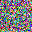

 10%|▉         | 97/1000 [00:02<00:22, 40.83it/s]

'Image at step 100'

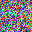

 15%|█▍        | 148/1000 [00:03<00:19, 44.45it/s]

'Image at step 150'

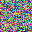

 20%|█▉        | 195/1000 [00:04<00:14, 55.88it/s]

'Image at step 200'

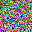

 25%|██▍       | 249/1000 [00:06<00:27, 27.47it/s]

'Image at step 250'

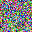

 30%|██▉       | 299/1000 [00:08<00:26, 26.11it/s]

'Image at step 300'

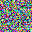

 35%|███▍      | 349/1000 [00:10<00:24, 26.28it/s]

'Image at step 350'

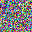

 40%|███▉      | 398/1000 [00:12<00:24, 24.31it/s]

'Image at step 400'

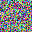

 45%|████▍     | 448/1000 [00:13<00:14, 38.54it/s]

'Image at step 450'

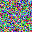

 50%|████▉     | 497/1000 [00:15<00:12, 40.01it/s]

'Image at step 500'

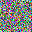

 55%|█████▍    | 548/1000 [00:16<00:11, 39.46it/s]

'Image at step 550'

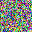

 60%|█████▉    | 595/1000 [00:17<00:09, 42.77it/s]

'Image at step 600'

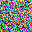

 65%|██████▍   | 648/1000 [00:18<00:06, 53.02it/s]

'Image at step 650'

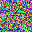

 70%|██████▉   | 696/1000 [00:19<00:05, 51.29it/s]

'Image at step 700'

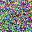

 74%|███████▍  | 744/1000 [00:20<00:04, 52.75it/s]

'Image at step 750'

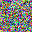

 80%|███████▉  | 798/1000 [00:21<00:03, 53.61it/s]

'Image at step 800'

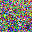

 85%|████████▍ | 846/1000 [00:22<00:02, 55.30it/s]

'Image at step 850'

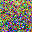

 89%|████████▉ | 894/1000 [00:23<00:02, 52.81it/s]

'Image at step 900'

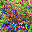

 95%|█████████▍| 948/1000 [00:24<00:00, 54.63it/s]

'Image at step 950'

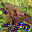

100%|█████████▉| 996/1000 [00:25<00:00, 53.73it/s]

'Image at step 1000'

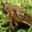

100%|██████████| 1000/1000 [00:25<00:00, 39.52it/s]

CPU times: user 22 s, sys: 192 ms, total: 22.2 s
Wall time: 25.3 s


In [34]:
%%time

sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler_ddpm_pretrained.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model_ddpm_pretrained(sample, t).sample

  # 2. compute less noisy image and set x_t -> x_t-1
  sample = scheduler_ddpm_pretrained.step(residual, t, sample).prev_sample

  # 3. optionally look at image
  if (i + 1) % 50 == 0:
      display_sample(sample, i + 1)

### Or, do it the fast way
Actually, this is much slower

In [37]:
%%time
# run pipeline in inference (sample random noise and denoise)
generated_images = ddpm_pretrained().images

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 5min 3s, sys: 1.15 s, total: 5min 4s
Wall time: 5min 11s


In [43]:
generated_images

[<PIL.Image.Image image mode=RGB size=32x32 at 0x7F4ADC856940>]

In [46]:
image = generated_images[0]

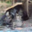

In [48]:
image

In [49]:
# save image
image.save("ddpm_generated_image.png")

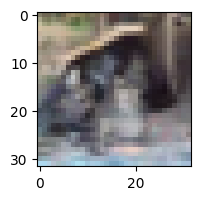

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# img = mpimg.imread('your_image.png')
plt.figure(figsize=(2,2))
imgplot = plt.imshow(image)
plt.show()

## FID Score
Implementation from https://github.com/mseitzer/pytorch-fid/blob/master/src/pytorch_fid/fid_score.py 